`First filter ACS data to contain only people between 20-50 years old by 2023`
- Melmedier: They first restricted the sample to respondents aged 20–80 and ensured that each person had inflation data covering their lifetime starting from at least 1961. This removes individuals whose birth years fall before the available inflation series.
- Me: First restrcit the sample to respondent aged 20-40 and ensure each person has inflation data covering their lifetime starting from at least 1966 (due to inflation data availability). 

- Melmendier data: American Community Survey (ACS) data from 2006 to 2020 (1-in-100 national random sample of the population), downloaded from IPUMS
- Me: American Community Survey (ACS) data from 2006 to 2023, with these variables: YEAR AGE, REGION (or STATEFIP, then map to regions), HHWT or PERWT (weights), OWNERSHP (homeownership), HHINCOME, EDUC, MARST, EMPSTAT.

`U.S Region breakdown`

`Preparing Inflation Data Set`

In [ ]:
import pandas as pd
import matplotlib.pyplot as pyplot
import smplotlib

df_MW = pd.read_excel("/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/MW_1966-2024.xlsx")
df_NE = pd.read_excel("/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/NE_1966-2024.xlsx")
df_ST = pd.read_excel("/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ST_1966-2024.xlsx")
df_WE = pd.read_excel("/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/WE_1966-2024.xlsx")

df_MW.to_csv("/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/MW_1966-2024.csv", index=False)
df_NE.to_csv("/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/NE_1966-2024.csv", index=False)
df_ST.to_csv("/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ST_1966-2024.csv", index=False)
df_WE.to_csv("/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/WE_1966-2024.csv", index=False)



In [5]:
#df_WE.columns
#df_WE.head(10)

`Cleaning Inflation Data`
- Loops over MW, NE, ST, WE
- Finds the correct header row (Year, Jan, Feb, ...)
- Drops Unnamed columns
- Converts Year → int, CPI values → float
- Saves a clean full monthly file and an annual-only file for each region

In [6]:
import pandas as pd
from pathlib import Path

base_dir = Path("/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience")

regions = ["MW", "NE", "ST", "WE"]


In [9]:
import pandas as pd
from pathlib import Path

base_dir = Path("/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience")
regions = ["MW", "NE", "ST", "WE"]

def extract_annual_cpi(input_path: Path, output_path: Path):
    # Read raw file without header to find the "Year" row
    raw = pd.read_csv(input_path, header=None)

    header_row_candidates = raw.index[raw.iloc[:, 0] == "Year"]
    if len(header_row_candidates) == 0:
        raise ValueError(f"No 'Year' header row found in {input_path}")
    header_row = header_row_candidates[0]

    # Read again using that row as header
    df = pd.read_csv(input_path, header=header_row)

    # Drop Unnamed columns
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

    # Keep only Year + Annual
    if "Annual" not in df.columns:
        raise ValueError(f"'Annual' column not found in {input_path}. Columns are: {df.columns.tolist()}")

    df = df[["Year", "Annual"]]

    # Clean numeric types
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    df["Annual"] = pd.to_numeric(df["Annual"], errors="coerce")

    # Drop rows without Year or Annual
    df = df.dropna(subset=["Year", "Annual"])
    df["Year"] = df["Year"].astype("int64")

    # Save clean annual CPI
    df.to_csv(output_path, index=False)
    print(f"Saved annual CPI to: {output_path}")

for reg in regions:
    input_path = base_dir / f"{reg}_1966-2024.csv"
    output_path = base_dir / f"{reg}_1966-2024_clean_annual.csv"
    print(f"Processing {reg}...")
    extract_annual_cpi(input_path, output_path)


Processing MW...
Saved annual CPI to: /Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/MW_1966-2024_clean_annual.csv
Processing NE...
Saved annual CPI to: /Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/NE_1966-2024_clean_annual.csv
Processing ST...
Saved annual CPI to: /Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ST_1966-2024_clean_annual.csv
Processing WE...
Saved annual CPI to: /Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/WE_1966-2024_clean_annual.csv


In [10]:
import pandas as pd
from pathlib import Path

base_dir = Path("/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience")

# Mapping from your short codes to region_name used in ACS
region_map = {
    "MW": "Midwest",
    "NE": "Northeast",
    "ST": "South",
    "WE": "West"
}

all_dfs = []

for code, name in region_map.items():
    input_path = base_dir / f"{code}_1966-2024_clean_annual.csv"
    df = pd.read_csv(input_path)

    # Standardize columns
    df = df.rename(columns={"Year": "year", "Annual": "annual_cpi"})
    df["region_name"] = name

    all_dfs.append(df)

# 1. Combine all four regions into a single DataFrame
inflation_df = pd.concat(all_dfs, ignore_index=True)

# 2. Sort by region and year
inflation_df = inflation_df.sort_values(by=["region_name", "year"])

# 3. Compute annual inflation rate by region
#    π_t = (CPI_t - CPI_{t-1}) / CPI_{t-1} * 100
inflation_df["annual_inflation"] = (
    inflation_df
    .groupby("region_name")["annual_cpi"]
    .pct_change() * 100
)

# (Optional) Drop first year per region (no prior year to compare)
inflation_df = inflation_df.dropna(subset=["annual_inflation"])

# 4. Save final dataset
output_path = base_dir / "annual_inflation_by_region_1966_2024.csv"
inflation_df.to_csv(output_path, index=False)

print("Saved combined inflation file to:", output_path)
inflation_df.head()


Saved combined inflation file to: /Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/annual_inflation_by_region_1966_2024.csv


,year,annual_cpi,region_name,annual_inflation
1,1968,34.8,Midwest,4.191617
2,1969,36.8,Midwest,5.747126
3,1970,38.8,Midwest,5.434783
4,1971,40.3,Midwest,3.865979
5,1972,41.5,Midwest,2.977667


In [11]:
import pandas as pd
from pathlib import Path

base_dir = Path("/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience")

# Load the combined dataset you created earlier
inflation_path = base_dir / "annual_inflation_by_region_1966_2024.csv"
inflation_df = pd.read_csv(inflation_path)

# Drop annual_cpi
inflation_df = inflation_df.drop(columns=["annual_cpi"])

# Save cleaned file
output_path = base_dir / "annual_inflation_only_1966_2024.csv"
inflation_df.to_csv(output_path, index=False)

print("Saved dataset WITHOUT annual_cpi to:", output_path)
inflation_df.head()


Saved dataset WITHOUT annual_cpi to: /Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/annual_inflation_only_1966_2024.csv


,year,region_name,annual_inflation
0,1968,Midwest,4.191617
1,1969,Midwest,5.747126
2,1970,Midwest,5.434783
3,1971,Midwest,3.865979
4,1972,Midwest,2.977667


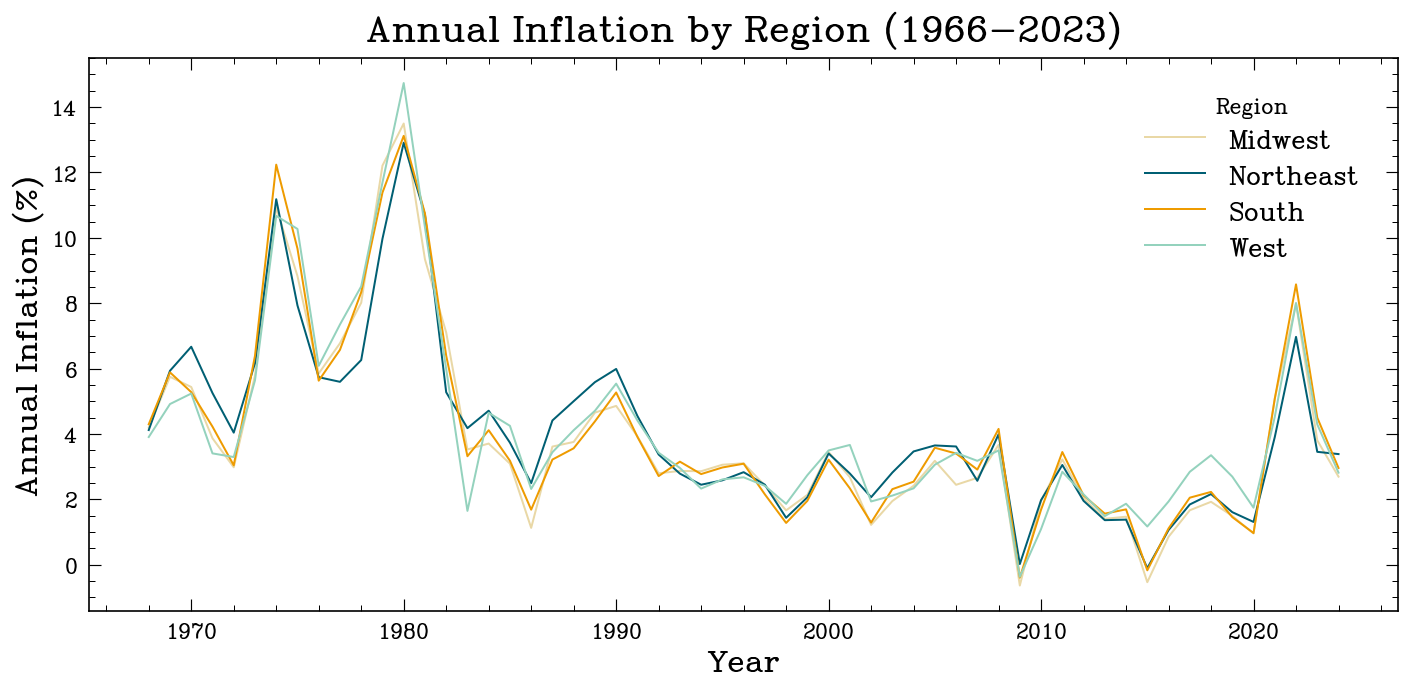

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
# If smplotlib is installed, you can keep this import, 
# but the coloring logic uses standard Matplotlib.
import smplotlib 

df = pd.read_csv("annual_inflation_only_1966_2024.csv")

# 1. Define the Custom Color Map
region_colors = {
    'West': '#94d2bd',        # Greenish-Blue
    'Midwest': '#e9d8a6',     # Pale Gold
    'South': '#ee9b00',       # Darker Orange/Amber
    'Northeast': '#005f73'    # Dark Teal
}

# Optional: restrict to 1966–2023
# df = df[(df["year"] >= 1966) & (df["year"] <= 2023)]

# Create plot
plt.figure(figsize=(12, 6))

# 2. Loop through each region and plot its line using the custom color
for region in df["region_name"].unique():
    temp = df[df["region_name"] == region]
    
    # Check if the region has a defined color, and use it
    color_to_use = region_colors.get(region, 'gray') # Default to 'gray' if region isn't in the dict
    
    plt.plot(
        temp["year"], 
        temp["annual_inflation"], 
        label=region,
        color=color_to_use  # <-- THIS APPLIES YOUR CUSTOM COLOR
    )

plt.xlabel("Year", fontsize=22)
plt.ylabel("Annual Inflation (%)", fontsize=22)
plt.title("Annual Inflation by Region (1966-2023)", fontsize=26)
plt.legend(title="Region", fontsize=18)
plt.grid(False)
# Remove ticks
#plt.gca().set_xticks([])  # Removes x-axis ticks
#plt.gca().set_yticks([])  # Removes y-axis ticks
plt.tight_layout()
plt.savefig("Annual_inflation_by_region.png") 

plt.show()

In [16]:
df.describe()

,year,annual_inflation
count,228.000000,228.000000
mean,1996.000000,4.044218
std,16.488148,2.831617
min,1968.000000,-0.641731
25%,1982.000000,2.207510
50%,1996.000000,3.357498
75%,2010.000000,5.077554
max,2024.000000,14.738292


`Preparing ACS Data Set`

In [1]:
import pandas as pd

# File paths
input_path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023.csv.gz"
output_path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023_clean.csv.gz"

# Chunk size (adjust if needed)
chunksize = 250000  # 250K rows at a time

# Trackers
total_rows_before = 0
total_rows_after = 0
first_write = True

print("Starting chunked cleaning...")

# Process file in chunks
for chunk in pd.read_csv(input_path, compression="gzip", chunksize=chunksize):

    # Count rows before filtering
    total_rows_before += len(chunk)

    # Filter out unwanted YEAR < 2006
    chunk_clean = chunk[chunk["YEAR"] >= 2006]

    # Count rows after filtering
    total_rows_after += len(chunk_clean)

    # Write to output file
    chunk_clean.to_csv(
        output_path,
        mode="w" if first_write else "a",  # write first chunk, append next chunks
        header=first_write,                # header only for first chunk
        index=False,
        compression="gzip"
    )

    first_write = False

print("Finished! Clean dataset saved at:")
print(output_path)
print("Rows before:", total_rows_before)
print("Rows after:", total_rows_after)


Starting chunked cleaning...
Finished! Clean dataset saved at:
/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023_clean.csv.gz
Rows before: 58198062
Rows after: 56168396


In [ ]:
#Filtering for peole between 20-40 years old

In [3]:
import pandas as pd

input_path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023_clean.csv.gz"
output_path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023_filtered_20-40.csv.gz"

# Load in chunks so it doesn't crash
chunksize = 250000
first_write = True

for chunk in pd.read_csv(input_path, compression="gzip", chunksize=chunksize):

    # Filter for age 20–40
    chunk = chunk[(chunk["AGE"] >= 20) & (chunk["AGE"] <= 40)]

    # Write filtered chunk
    chunk.to_csv(
        output_path,
        mode="w" if first_write else "a",
        header=first_write,
        index=False,
        compression="gzip"
    )

    first_write = False

print("Filtered dataset saved to:")
print(output_path)


Filtered dataset saved to:
/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023_filtered_20-40.csv.gz


`The Structure`:
- A birth year
 Their age in each survey year
- Create person identifier
- Region of residence mapped to inflation region
- Complete annual inflation history from birth year → survey year
- A weighting scheme (recent inflation receives more weight)

In [4]:
#Calculating the birthyear
import pandas as pd

input_path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023_filtered_20-40.csv.gz"
output_path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023_with_birthyear.csv.gz"

# Load dataset
df = pd.read_csv(input_path, compression="gzip")

# Compute birth year
df["birth_year"] = df["YEAR"] - df["AGE"]

# Save new dataset
df.to_csv(output_path, index=False, compression="gzip")

print("Finished! Saved dataset with birth_year at:")
print(output_path)

# Optional: check summary
print(df["birth_year"].describe())


Finished! Saved dataset with birth_year at:
/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023_with_birthyear.csv.gz
count    1.395997e+07
mean     1.984544e+03
std      8.026787e+00
min      1.966000e+03
25%      1.979000e+03
50%      1.985000e+03
75%      1.990000e+03
max      2.003000e+03
Name: birth_year, dtype: float64


In [5]:
df.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,REGION,STATEFIP,STRATA,GQ,...,HHINCOME,PERNUM,PERWT,AGE,MARST,EDUC,EDUCD,EMPSTAT,EMPSTATD,birth_year
0,2006,200601,2,280.0,105.0,2006000000021,32,1,170001,1,...,78300.0,3,114.0,30,6,7,71,1,10,1976
1,2006,200601,4,382.0,69.0,2006000000041,32,1,220001,1,...,408500.0,1,69.0,30,1,11,115,1,10,1976
2,2006,200601,4,382.0,69.0,2006000000041,32,1,220001,1,...,408500.0,2,58.0,38,1,11,115,1,10,1968
3,2006,200601,5,400.0,19.0,2006000000051,32,1,110001,1,...,38100.0,1,18.0,38,1,6,62,1,10,1968
4,2006,200601,5,400.0,19.0,2006000000051,32,1,110001,1,...,38100.0,2,20.0,36,1,6,62,3,30,1970


In [6]:
#Creating person identifier
import pandas as pd

input_path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023_with_birthyear.csv.gz"
output_path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023_with_personid.csv.gz"

# Load dataset
df = pd.read_csv(input_path, compression="gzip")

# Create person ID
df["person_id"] = (
    df["YEAR"].astype(str) + "_" +
    df["SAMPLE"].astype(str) + "_" +
    df["SERIAL"].astype(str) + "_" +
    df["PERNUM"].astype(str)
)

# Save new dataset
df.to_csv(output_path, index=False, compression="gzip")

print("Finished! Saved dataset with person_id at:")
print(output_path)

# Optional: preview first few IDs
print(df[["YEAR", "SAMPLE", "SERIAL", "PERNUM", "person_id"]].head())


Finished! Saved dataset with person_id at:
/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023_with_personid.csv.gz
   YEAR  SAMPLE  SERIAL  PERNUM        person_id
0  2006  200601       2       3  2006_200601_2_3
1  2006  200601       4       1  2006_200601_4_1
2  2006  200601       4       2  2006_200601_4_2
3  2006  200601       5       1  2006_200601_5_1
4  2006  200601       5       2  2006_200601_5_2


In [7]:
df.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,REGION,STATEFIP,STRATA,GQ,...,PERNUM,PERWT,AGE,MARST,EDUC,EDUCD,EMPSTAT,EMPSTATD,birth_year,person_id
0,2006,200601,2,280.0,105.0,2006000000021,32,1,170001,1,...,3,114.0,30,6,7,71,1,10,1976,2006_200601_2_3
1,2006,200601,4,382.0,69.0,2006000000041,32,1,220001,1,...,1,69.0,30,1,11,115,1,10,1976,2006_200601_4_1
2,2006,200601,4,382.0,69.0,2006000000041,32,1,220001,1,...,2,58.0,38,1,11,115,1,10,1968,2006_200601_4_2
3,2006,200601,5,400.0,19.0,2006000000051,32,1,110001,1,...,1,18.0,38,1,6,62,1,10,1968,2006_200601_5_1
4,2006,200601,5,400.0,19.0,2006000000051,32,1,110001,1,...,2,20.0,36,1,6,62,3,30,1970,2006_200601_5_2


In [8]:
#Mapping inflation:
import pandas as pd

input_path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023_with_personid.csv.gz"
output_path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023_with_regionname.csv.gz"

# Load dataset
df = pd.read_csv(input_path, compression="gzip")

# Mapping dictionary
region_map = {
    11: "Northeast",
    12: "Northeast",
    21: "Midwest",
    22: "Midwest",
    31: "South",
    32: "South",
    33: "South",
    41: "West",
    42: "West"
}

# Create region_name column
df["region_name"] = df["REGION"].map(region_map)

# Save file with mapped regions
df.to_csv(output_path, index=False, compression="gzip")

print("Finished! Saved dataset with region names at:")
print(output_path)

# Optional: verify mapping
print(df[["REGION", "region_name"]].head())


Finished! Saved dataset with region names at:
/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023_with_regionname.csv.gz
   REGION region_name
0      32       South
1      32       South
2      32       South
3      32       South
4      32       South


In [9]:
df.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,REGION,STATEFIP,STRATA,GQ,...,PERWT,AGE,MARST,EDUC,EDUCD,EMPSTAT,EMPSTATD,birth_year,person_id,region_name
0,2006,200601,2,280.0,105.0,2006000000021,32,1,170001,1,...,114.0,30,6,7,71,1,10,1976,2006_200601_2_3,South
1,2006,200601,4,382.0,69.0,2006000000041,32,1,220001,1,...,69.0,30,1,11,115,1,10,1976,2006_200601_4_1,South
2,2006,200601,4,382.0,69.0,2006000000041,32,1,220001,1,...,58.0,38,1,11,115,1,10,1968,2006_200601_4_2,South
3,2006,200601,5,400.0,19.0,2006000000051,32,1,110001,1,...,18.0,38,1,6,62,1,10,1968,2006_200601_5_1,South
4,2006,200601,5,400.0,19.0,2006000000051,32,1,110001,1,...,20.0,36,1,6,62,3,30,1970,2006_200601_5_2,South


In [10]:
#Creating the inflation experience variable: using recency bias

import pandas as pd
import numpy as np

acs_path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_2006-2023_with_regionname.csv.gz"
infl_path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/annual_inflation_only_1966_2024.csv"  

acs = pd.read_csv(acs_path, compression="gzip")
infl = pd.read_csv(infl_path)


In [12]:
infl_pivot = infl.pivot(index="year", columns="region_name", values="annual_inflation")


In [ ]:
#function to extract the lifetime inflation series:
def get_inflation_series(birth, survey, region):
    """
    Returns a numpy array of inflation rates from birth_year to survey_year
    for the specified region.
    """
    return infl_pivot.loc[birth:survey, region].values

#Showing me an array with all the inflation years of the person selected 
#Start at inflation in 1995
#End at inflation in 2020
#Contain 26 values (because 2020 − 1995 + 1 = 26)
#Represent South region inflation only

In [14]:
get_inflation_series(1995, 2020, "South")


array([ 2.97166551,  3.08724832,  2.1484375 ,  1.27469726,  1.95091252,
        3.20987654,  2.33253589,  1.28579778,  2.30813618,  2.53807107,
        3.57535754,  3.39883165,  2.90755008,  4.15250473, -0.40061146,
        1.68057928,  3.44471889,  2.11510489,  1.55839851,  1.68974202,
       -0.17566536,  1.10581498,  2.04734155,  2.22399097,  1.4534249 ,
        0.96400219])

In [16]:
#compute inflation series in batches
def compute_series_batch(df):
    result = []
    
    # Loop over each person in the dataframe
    for birth, survey, region in zip(df["birth_year"], df["YEAR"], df["region_name"]):
        
        # Extract inflation from birth_year to survey_year for that region
        series = infl_pivot.loc[birth:survey, region].values
        
        # Store this person’s inflation series
        result.append(series)
    
    # Return a list where each element is a person’s inflation history
    return result




In [18]:
acs["infl_series"] = compute_series_batch(acs)


In [ ]:
acs[["birth_year", "YEAR", "region_name", "infl_series", "person_id"]].head()



,birth_year,YEAR,region_name,infl_series,person_id
0,1976,2006,South,"[5.628517823639778, 6.571936056838368, 8.33333...",2006_200601_2_3
1,1976,2006,South,"[5.628517823639778, 6.571936056838368, 8.33333...",2006_200601_4_1
2,1968,2006,South,"[4.294478527607359, 5.882352941176472, 5.27777...",2006_200601_4_2
3,1968,2006,South,"[4.294478527607359, 5.882352941176472, 5.27777...",2006_200601_5_1
4,1970,2006,South,"[5.277777777777781, 4.221635883905006, 3.03797...",2006_200601_5_2


In [24]:
# Compute weighted inflation experience: We are finding the weighted sum
# Following Melmedier we are compiling the inflation history of a person into a single number
# The logic for the recency decay can be easily explained through an example: 
# A value of 0.97 means inflation from 1 year ago is weighted at 97% of the weight of this year.
# Inflation from 2 years ago is weighted at 0.97².
# Inflation from 10 years ago is weighted at 0.97¹⁰.

import numpy as np

def weighted_average_experience(series, theta=0.97):
    T = len(series)
    weights = theta ** np.arange(T-1, -1, -1)
    return np.sum(series * weights) / np.sum(weights)

acs["infl_experience"] = acs["infl_series"].apply(weighted_average_experience)




In [25]:
acs.loc[0, ["infl_series", "infl_experience"]]


infl_series        [5.628517823639778, 6.571936056838368, 8.33333...
infl_experience                                             3.814248
Name: 0, dtype: object

In [28]:
acs.columns

Index(['YEAR', 'SAMPLE', 'SERIAL', 'CBSERIAL', 'HHWT', 'CLUSTER', 'REGION',
       'STATEFIP', 'STRATA', 'GQ', 'OWNERSHP', 'OWNERSHPD', 'HHINCOME',
       'PERNUM', 'PERWT', 'AGE', 'MARST', 'EDUC', 'EDUCD', 'EMPSTAT',
       'EMPSTATD', 'birth_year', 'person_id', 'region_name', 'infl_series',
       'infl_experience'],
      dtype='object')

In [29]:
acs.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,REGION,STATEFIP,STRATA,GQ,...,MARST,EDUC,EDUCD,EMPSTAT,EMPSTATD,birth_year,person_id,region_name,infl_series,infl_experience
0,2006,200601,2,280.0,105.0,2006000000021,32,1,170001,1,...,6,7,71,1,10,1976,2006_200601_2_3,South,"[5.628517823639778, 6.571936056838368, 8.33333...",3.814248
1,2006,200601,4,382.0,69.0,2006000000041,32,1,220001,1,...,1,11,115,1,10,1976,2006_200601_4_1,South,"[5.628517823639778, 6.571936056838368, 8.33333...",3.814248
2,2006,200601,4,382.0,69.0,2006000000041,32,1,220001,1,...,1,11,115,1,10,1968,2006_200601_4_2,South,"[4.294478527607359, 5.882352941176472, 5.27777...",4.141109
3,2006,200601,5,400.0,19.0,2006000000051,32,1,110001,1,...,1,6,62,1,10,1968,2006_200601_5_1,South,"[4.294478527607359, 5.882352941176472, 5.27777...",4.141109
4,2006,200601,5,400.0,19.0,2006000000051,32,1,110001,1,...,1,6,62,3,30,1970,2006_200601_5_2,South,"[5.277777777777781, 4.221635883905006, 3.03797...",4.113932


In [30]:
acs["homeowner"] = (acs["OWNERSHP"] == 1).astype(int)


In [31]:
acs["homeowner"].value_counts(normalize=True)


homeowner
1    0.556147
0    0.443853
Name: proportion, dtype: float64

`Saving Data Sets for Future Reference`

In [32]:
#saving data set with the inflation series for each row
acs.to_parquet("ACS_full_with_inflseries.parquet")


In [33]:
#Saving data set without inflation series for running the regressions more efficiently
del acs["infl_series"]
acs.to_parquet("ACS_regression_ready_regress.parquet")


In [ ]:
import pandas as pd

file_path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_regression_ready_regress.parquet"

# Load parquet
df = pd.read_parquet(file_path)

# Show the first rows
print(df.head())

# Show all column names
print(df.columns)

# Optional: show dimensions
print(df.shape)


   YEAR  SAMPLE  SERIAL  CBSERIAL   HHWT        CLUSTER  REGION  STATEFIP  \
0  2006  200601       2     280.0  105.0  2006000000021      32         1   
1  2006  200601       4     382.0   69.0  2006000000041      32         1   
2  2006  200601       4     382.0   69.0  2006000000041      32         1   
3  2006  200601       5     400.0   19.0  2006000000051      32         1   
4  2006  200601       5     400.0   19.0  2006000000051      32         1   

   STRATA  GQ  ...  MARST  EDUC  EDUCD  EMPSTAT  EMPSTATD  birth_year  \
0  170001   1  ...      6     7     71        1        10        1976   
1  220001   1  ...      1    11    115        1        10        1976   
2  220001   1  ...      1    11    115        1        10        1968   
3  110001   1  ...      1     6     62        1        10        1968   
4  110001   1  ...      1     6     62        3        30        1970   

         person_id  region_name  infl_experience  homeowner  
0  2006_200601_2_3        South     

`Visuals for inflation experience`

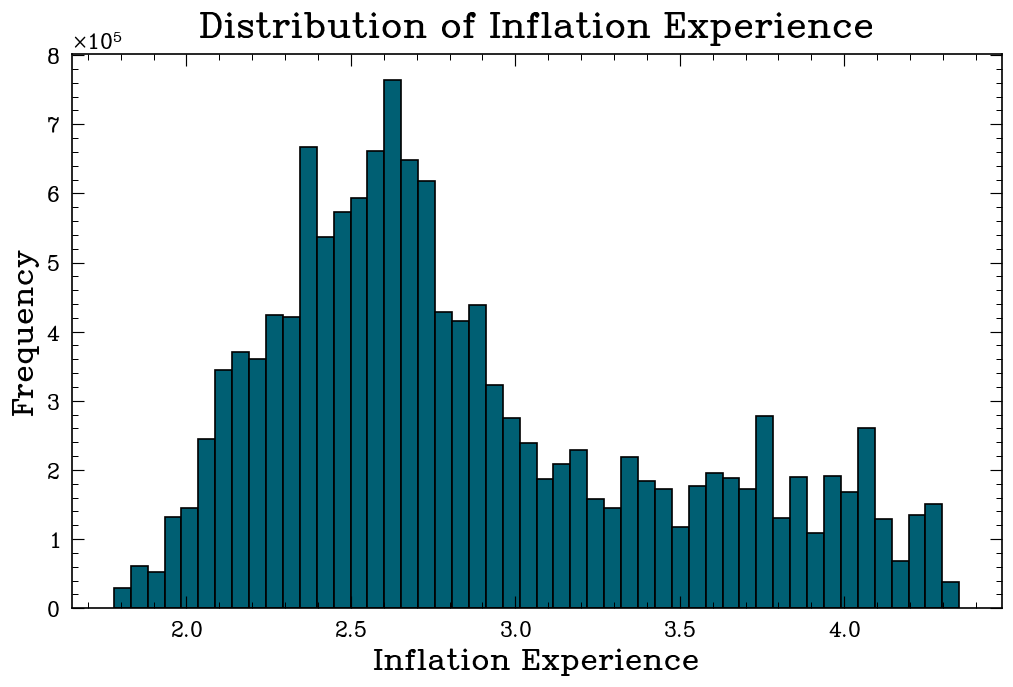

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import smplotlib

# 1. Load your dataset
path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_regression_ready_regress.parquet"
df = pd.read_parquet(path)

# 2. Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df["infl_experience"], bins=50, color="#005f73", edgecolor= 'black')

plt.title("Distribution of Inflation Experience", fontsize=26)
plt.xlabel("Inflation Experience", fontsize=22)
plt.ylabel("Frequency", fontsize = 22)
plt.savefig("Distribution_infl_experince")

plt.grid(False)
plt.show()


`Log of inflation experience`
- The distribution is right-skewed
Experience measures often have long right tails; taking logs makes the variable more symmetric.

- You want percentage changes rather than level changes
A log transformation turns changes into proportional changes.

- You believe the effect on homeownership is multiplicative (diminishing marginal effect)
This means an increase in inflation experience from 2→3 has a larger effect than 3→4 in levels, but similar in percentage terms.

- You want to reduce influence from extreme values
Logs compress large values and reduce leverage from outliers.

In [15]:
import pandas as pd
import numpy as np

# File paths
input_path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_regression_ready_regress.parquet"
output_path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_regression_with_loginfl.parquet"

# 1. Load the original dataset
df = pd.read_parquet(input_path)

# 2. Make a copy so the original is not modified
df_copy = df.copy()

# 3. Create the log of inflation experience
# (Handles zero or negative values safely)
df_copy["log_infl_experience"] = np.log(df_copy["infl_experience"])

# 4. Save the new dataset
df_copy.to_parquet(output_path, index=False)

print("Done! New dataset saved at:")
print(output_path)


Done! New dataset saved at:
/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_regression_with_loginfl.parquet


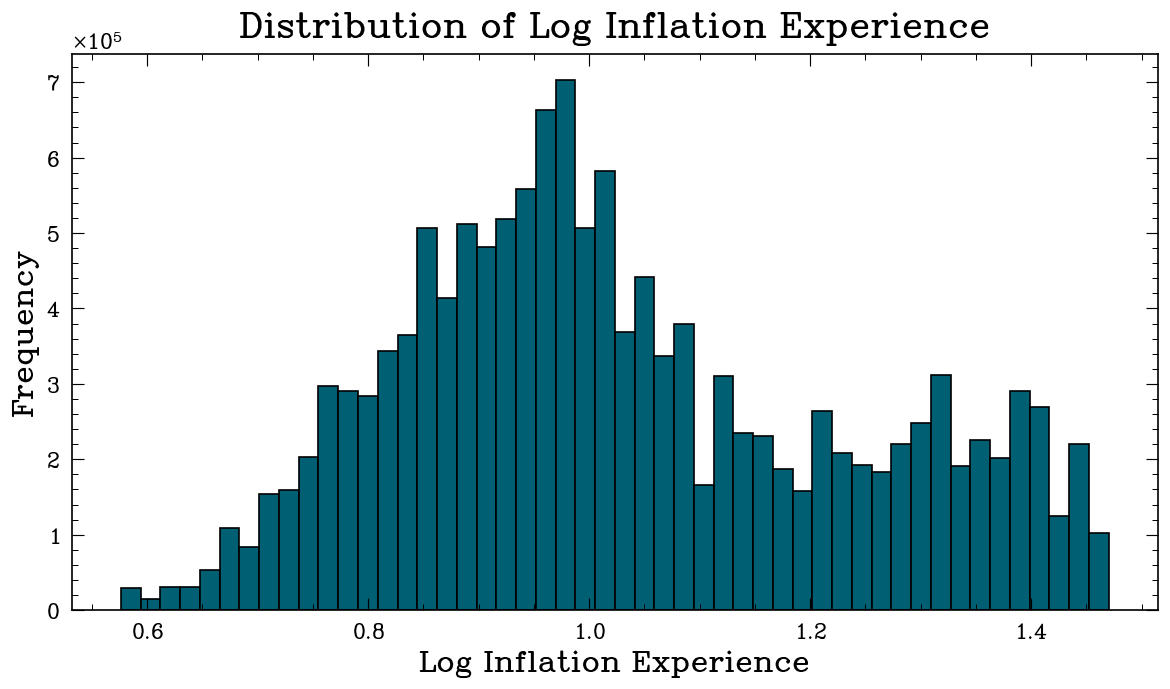

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_regression_with_loginfl.parquet"
df = pd.read_parquet(path)

# If log variable not created yet, uncomment this line:
# df["log_infl_experience"] = np.log(df["infl_experience"])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df["log_infl_experience"], bins=50, color="#005f73", edgecolor= 'black')
plt.xlabel("Log Inflation Experience", fontsize =22)
plt.ylabel("Frequency", fontsize = 22)
plt.title("Distribution of Log Inflation Experience", fontsize =26)
plt.tight_layout()
plt.savefig("log_infl_experience.png")
plt.show()


`For Paper`

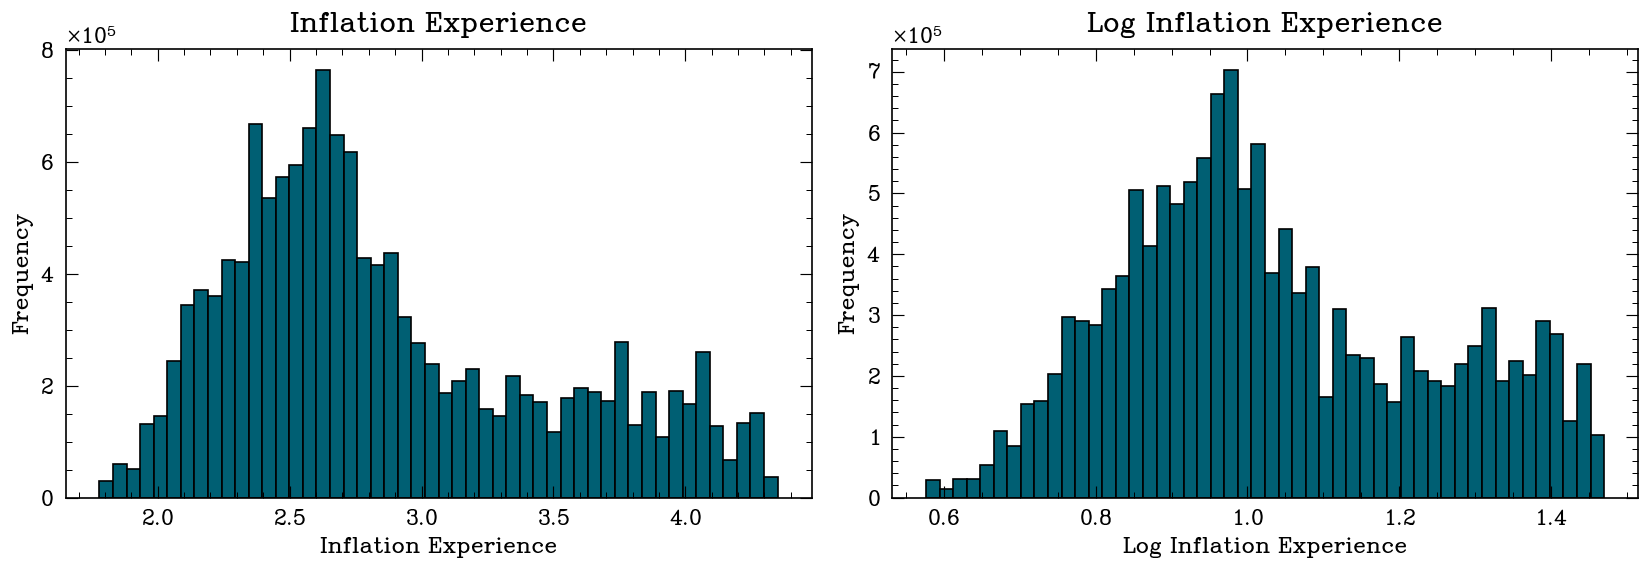

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset (the one containing log_infl_experience)
path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_regression_with_loginfl.parquet"
df = pd.read_parquet(path)

# If LOG variable isn't in your file yet, uncomment:
# df["log_infl_experience"] = np.log(df["infl_experience"])

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# ----------------------------------------
# Plot 1: Inflation Experience
# ----------------------------------------
axes[0].hist(df["infl_experience"], bins=50, color="#005f73", edgecolor="black")
axes[0].set_title("Inflation Experience", fontsize=20)
axes[0].set_xlabel("Inflation Experience", fontsize=16)
axes[0].set_ylabel("Frequency", fontsize=16)
axes[0].grid(False)

# ----------------------------------------
# Plot 2: Log Inflation Experience
# ----------------------------------------
axes[1].hist(df["log_infl_experience"], bins=50, color="#005f73", edgecolor="black")
axes[1].set_title("Log Inflation Experience", fontsize=20)
axes[1].set_xlabel("Log Inflation Experience", fontsize=16)
axes[1].set_ylabel("Frequency", fontsize=16)
axes[1].grid(False)

# Ensure consistent layout
plt.tight_layout()

# Save combined figure
plt.savefig("inflation_experience_combined.png", dpi=300, bbox_inches="tight")

# Show the final combined plot
plt.show()


`Statistical Summary of Inflation Experience`

In [2]:
import pandas as pd

# Load dataset
path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_regression_ready_regress.parquet"
df = pd.read_parquet(path)

# Summary statistics for inflation experience
summary_table = df["infl_experience"].describe(percentiles=[0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99])

# Show the table
print(summary_table)

# If you want it as a cleaner DataFrame:
summary_df = summary_table.to_frame(name="Inflation Experience Summary")
print(summary_df)


count    1.395997e+07
mean     2.865236e+00
std      6.011190e-01
min      1.779359e+00
1%       1.933447e+00
5%       2.093161e+00
10%      2.191828e+00
50%      2.698059e+00
90%      3.856416e+00
95%      4.058179e+00
99%      4.269805e+00
max      4.349773e+00
Name: infl_experience, dtype: float64
       Inflation Experience Summary
count                  1.395997e+07
mean                   2.865236e+00
std                    6.011190e-01
min                    1.779359e+00
1%                     1.933447e+00
5%                     2.093161e+00
10%                    2.191828e+00
50%                    2.698059e+00
90%                    3.856416e+00
95%                    4.058179e+00
99%                    4.269805e+00
max                    4.349773e+00


Key takeaways:
- The distribution is right skewed
- long-right tail skew - it is peole who lived in the 1960-80s because they ecperienced very high inflation
- Skeweness doesn't invalidate OLS
- `x-axis`: value of inflation experience
- `y-axis`: #of people who fall into that value of inflation experience. i.e. if a bar reaches 700,000, that means 700,000 individuals have an inflation experience around that x-axis value.


`Running first regression`

In [35]:
import pandas as pd
import statsmodels.api as sm

# Load dataset
path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_regression_ready_regress.parquet"
df = pd.read_parquet(path)

# Define dependent and independent variables
y = df["homeowner"]
X = df["infl_experience"]

# Add constant term for OLS
X = sm.add_constant(X)

# Run OLS regression
model = sm.OLS(y, X).fit()

# Print results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              homeowner   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                 1.557e+05
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:43:47   Log-Likelihood:            -9.9660e+06
No. Observations:            13959970   AIC:                         1.993e+07
Df Residuals:                13959968   BIC:                         1.993e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3075      0.001    4

`Interpretation of Beta inflation experience`: A one-unit increase in lifetime inflation experience is associated with an 8.7-percentage-point higher probability of being a homeowner.

`Regression with Control Variables`

In [36]:
import pandas as pd
import statsmodels.api as sm

# Load the dataset
path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_regression_ready_regress.parquet"
df = pd.read_parquet(path)

# -------------------------
# Select regression variables
# -------------------------
y = df["homeowner"]

X = df[[
    "infl_experience",
    "AGE",
    "HHINCOME",
    "EDUC",      # numeric education code
    "MARST",     # marital status code
    "EMPSTAT"    # employment status code
]]

# Add a constant term for OLS
X = sm.add_constant(X)

# -------------------------
# Run OLS regression
# -------------------------
model = sm.OLS(y, X).fit()

# -------------------------
# Print results
# -------------------------
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              homeowner   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                 3.096e+05
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:56:34   Log-Likelihood:            -9.1713e+06
No. Observations:            13959970   AIC:                         1.834e+07
Df Residuals:                13959963   BIC:                         1.834e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3906      0.001    3

`Regression with all region and year fixed effects`

In [2]:
from linearmodels.panel import PanelOLS
import pandas as pd

# Load dataset
path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_regression_ready_regress.parquet"
df = pd.read_parquet(path)

# Set a multi-index for panel structure: (region, year)
df = df.set_index(["region_name", "YEAR"])

# Define the regression
model = PanelOLS.from_formula(
    "homeowner ~ infl_experience + AGE + HHINCOME + EDUC + MARST + EMPSTAT + EntityEffects + TimeEffects",
    data=df
)

results = model.fit(cov_type="clustered", cluster_entity=True)
print(results)


                          PanelOLS Estimation Summary                           
Dep. Variable:              homeowner   R-squared:                        0.1170
Estimator:                   PanelOLS   R-squared (Between):              0.6860
No. Observations:            13959970   R-squared (Within):               0.1164
Date:                Sun, Dec 07 2025   R-squared (Overall):              0.4359
Time:                        22:06:58   Log-likelihood                -9.101e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.083e+05
Entities:                           4   P-value                           0.0000
Avg Obs:                     3.49e+06   Distribution:              F(6,13959943)
Min Obs:                    2.449e+06                                           
Max Obs:                     5.14e+06   F-statistic (robust):         -5.211e+17
                            

`Full regression + clustered standard erros at region and year`

In [4]:
import pandas as pd
from linearmodels.panel import PanelOLS

# Load regression-ready dataset
path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_regression_ready_regress.parquet"
df = pd.read_parquet(path)

# We cluster at STATEFIP, so set the index as (STATEFIP, YEAR)
df = df.set_index(["region_name", "YEAR"])

# Run regression with FE + clustering
model = PanelOLS.from_formula(
    """
    homeowner ~ infl_experience + AGE + HHINCOME + EDUC + MARST + EMPSTAT
    + EntityEffects + TimeEffects
    """,
    data=df
)

results = model.fit(cov_type="clustered", cluster_entity=True)
print(results)


                          PanelOLS Estimation Summary                           
Dep. Variable:              homeowner   R-squared:                        0.1170
Estimator:                   PanelOLS   R-squared (Between):              0.6860
No. Observations:            13959970   R-squared (Within):               0.1164
Date:                Tue, Dec 09 2025   R-squared (Overall):              0.4359
Time:                        19:58:39   Log-likelihood                -9.101e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.083e+05
Entities:                           4   P-value                           0.0000
Avg Obs:                     3.49e+06   Distribution:              F(6,13959943)
Min Obs:                    2.449e+06                                           
Max Obs:                     5.14e+06   F-statistic (robust):         -5.211e+17
                            

`Robustness Check`

`1st Robustness Check`: Is for the education levels

In [1]:
import pandas as pd
from linearmodels.panel import PanelOLS

# -----------------------------
# Load dataset
# -----------------------------
path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_regression_ready_regress.parquet"
df = pd.read_parquet(path)

# -----------------------------
# Create education categories
# -----------------------------
def map_educ(x):
    if x in [1, 2, 3, 4, 5]:  # less than high school
        return "less_than_hs"
    elif x == 6:             # high school graduate
        return "hs_grad"
    elif x in [7, 8, 9]:     # some college / associate degree (ACS normally codes 7–9)
        return "some_college"
    elif x in [10, 11, 12, 13]:  # BA, MA, professional, doctorate
        return "college_plus"
    else:
        return None

df["educ_group"] = df["EDUC"].apply(map_educ)

# Optional: check distribution
print(df["educ_group"].value_counts(dropna=False))

# -----------------------------
# Create interaction term (if needed later)
# -----------------------------
df["infl_age_interaction"] = df["infl_experience"] * df["AGE"]

# -----------------------------
# Set panel structure: (region, year)
# -----------------------------
df = df.set_index(["region_name", "YEAR"])

# -----------------------------
# Run regression with EDUCATION FE
# -----------------------------
model = PanelOLS.from_formula(
    "homeowner ~ infl_experience + AGE + HHINCOME + MARST + EMPSTAT + C(educ_group) + EntityEffects + TimeEffects",
    data=df
)

results = model.fit(cov_type="clustered", cluster_entity=True)

print(results)


educ_group
hs_grad         4599585
college_plus    4455237
some_college    3775493
less_than_hs     999172
None             130483
Name: count, dtype: int64
                          PanelOLS Estimation Summary                           
Dep. Variable:              homeowner   R-squared:                        0.1194
Estimator:                   PanelOLS   R-squared (Between):              0.6350
No. Observations:            13959970   R-squared (Within):               0.1194
Date:                Tue, Dec 09 2025   R-squared (Overall):              0.4086
Time:                        20:50:17   Log-likelihood                -9.082e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   2.103e+05
Entities:                           4   P-value                           0.0000
Avg Obs:                     3.49e+06   Distribution:              F(9,13959940)
Min Obs:                    2.449

* Another `Robustness Check` was to check: How much homeownership probability changes for a one standard deviation shift in inflation experience.

`Interpretation`: A one-standard-deviation increase in inflation experience is associated with a 1.33-percentage-point increase in the probability of homeownership.

In [ ]:
import pandas as pd
from linearmodels.panel import PanelOLS

# -------------------------------------------------------
# Load your dataset
# -------------------------------------------------------
path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_regression_ready_regress.parquet"
df = pd.read_parquet(path)

# -------------------------------------------------------
# Income fixed effects: Create quintiles to have 5 buckets of education to cluster
# -------------------------------------------------------
df["income_quintile"] = pd.qcut(
    df["HHINCOME"],
    q=5,
    labels=["Q1_lowest", "Q2", "Q3", "Q4", "Q5_highest"]
)

# Optional: Print distribution
print(df["income_quintile"].value_counts())

# -------------------------------------------------------
# Set panel index for region and year 
# -------------------------------------------------------
df = df.set_index(["region_name", "YEAR"])

# -------------------------------------------------------
# Regression with income fixed effects ONLY
# -------------------------------------------------------
model = PanelOLS.from_formula(
    "homeowner ~ infl_experience + AGE + MARST + EMPSTAT + C(income_quintile) + EntityEffects + TimeEffects",
    data=df
)

results = model.fit(cov_type="clustered", cluster_entity=True)
print(results)


income_quintile
Q2            2838594
Q1_lowest     2792168
Q5_highest    2791594
Q4            2789989
Q3            2747625
Name: count, dtype: int64
                          PanelOLS Estimation Summary                           
Dep. Variable:              homeowner   R-squared:                        0.1349
Estimator:                   PanelOLS   R-squared (Between):             -0.1908
No. Observations:            13959970   R-squared (Within):               0.1361
Date:                Tue, Dec 09 2025   R-squared (Overall):              0.1337
Time:                        21:04:32   Log-likelihood                -8.958e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                    2.72e+05
Entities:                           4   P-value                           0.0000
Avg Obs:                     3.49e+06   Distribution:              F(8,13959941)
Min Obs:                    2.449e+06 

`Heterogeinity Check`


In [5]:
#Creat interaction variable for age and inflation experience

from linearmodels.panel import PanelOLS
import pandas as pd

# Load data
path = "/Users/aleskamedrano/Real_Estate_SeminarFall2025/Final Versions/Inflation Experience/ACS_regression_ready_regress.parquet"
df = pd.read_parquet(path)

# Interaction term
df["infl_age_interaction"] = df["infl_experience"] * df["AGE"]

# Panel index for FE
df = df.set_index(["region_name", "YEAR"])

# Run the regression
model = PanelOLS.from_formula(
    "homeowner ~ infl_experience + AGE + infl_age_interaction + HHINCOME + EDUC + MARST + EMPSTAT + EntityEffects + TimeEffects",
    data=df
)

results = model.fit(cov_type="clustered", cluster_entity=True)
print(results)


                          PanelOLS Estimation Summary                           
Dep. Variable:              homeowner   R-squared:                        0.1179
Estimator:                   PanelOLS   R-squared (Between):             -1.3191
No. Observations:            13959970   R-squared (Within):               0.1191
Date:                Tue, Dec 09 2025   R-squared (Overall):             -0.6907
Time:                        20:22:47   Log-likelihood                -9.093e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   2.666e+05
Entities:                           4   P-value                           0.0000
Avg Obs:                     3.49e+06   Distribution:              F(7,13959942)
Min Obs:                    2.449e+06                                           
Max Obs:                     5.14e+06   F-statistic (robust):          3.344e+16
                            

In [6]:
b1 = results.params["infl_experience"]
b3 = results.params["infl_age_interaction"]

ME_20 = b1 + b3 * 20
ME_40 = b1 + b3 * 40

print("Effect at age 20:", ME_20)
print("Effect at age 40:", ME_40)
print("Difference (40 vs 20):", ME_40 - ME_20)


Effect at age 20: -0.04115530153035696
Effect at age 40: 0.0678913518378236
Difference (40 vs 20): 0.10904665336818056


- The Paper just proved that there is a positive relationship between inflation experiene and homownerhsip.
- Check the histogram and ask if skewness means it invalidates OLS?
- Not a diff-in-diff should I be looking to answer addiitonal questions?
- Robustness:
* Does truncating inflation experience at 10, 20, or 30 years change the effect (infl25, infl50, infl100)?
* Are results driven by a specific region?
* log to solve variance?
Check the heterogeinity:
- Does inflation experience matter more for low-income households?
- Does education moderate the effect?


Double check education years: some igh school, highschool, some college, college years. mae sure variables are coded in way that secifies the difference between.
Create dictionary to map years to some highschool, college, etc. to do education fixed effects. 
Distribution of income and create buckets of income: 5-7 buckets. 
Interpretation of beta and meaning of standard deviation. Standafd deviation times beta. does it happens in my data 
- log: normalize the distribution of the effect **
- Track average age at which people buy houses - age of 40
- HHIncome salaries - effect for them middle income earners. 
- By wave: construct the peole that ar ein top 25th percentile of experience inflation. Do by ages - year fixed effects. Poeple in top earners by-year. 
- Focus on different explanation
Income and age heterogeinity test - pre-disposed to be able to buy house

People with hgher inflaiton experiences should have higher effect of homwownerhsip because they view it as hedge!!!!